# Dataset: JAFFE

## Import Libraries

In [1]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils
from keras import callbacks
from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import urllib.request

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from keras import callbacks

## Data Collection

In [2]:
#Define Datapath
data_path = './JAFFE'
data_dir_list = os.listdir(data_path)
print(data_dir_list)
img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

['jaffedbase']
Loaded the images of dataset-jaffedbase



(213, 128, 128, 3)

In [3]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

In [4]:
# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [5]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


train_generator = train_datagen.flow(X_train,y_train,batch_size = 32)     


## Model Building

In [6]:
pre_trained_model = InceptionV3(input_shape = (128, 128, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [8]:
base_learning_rate = 0.0001

In [9]:
#EVALUATION

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
#EVALUATION

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [11]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(7, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss = 'categorical_crossentropy', 
              metrics = METRICS)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [13]:
# Create Callback Checkpoint
filepath="Best1.hdf5"
Checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.1,
                                                  patience=20,
                                                  min_lr=0.000005,
                                                  verbose=1)

callbacks_list1 = [Checkpoint, Reducing_LR]

In [14]:
initial_epoch = 20

In [15]:
history = model.fit(
            train_generator,
            epochs = initial_epoch,validation_data=(X_test,y_test),callbacks=callbacks_list1)

Epoch 1/20
6/6 [==============================] - 11s 593ms/step - loss: 2.2470 - accuracy: 0.8403 - precision: 0.1875 - recall: 0.0353 - auc: 0.5290 - f1_score: 0.0520 - val_loss: 1.9477 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5718 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
6/6 [==============================] - 2s 294ms/step - loss: 2.2571 - accuracy: 0.8412 - precision: 0.2432 - recall: 0.0529 - auc: 0.5669 - f1_score: 0.0767 - val_loss: 1.9234 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5810 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/20
6/6 [==============================] - 2s 285ms/step - loss: 2.4017 - accuracy: 0.8403 - precision: 0.2059 - recall: 0.0412 - auc: 0.5169 - f1_score: 0.0598 - val_loss: 1.8560 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6236 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/20
6/6 [========

## Quantitative Evaluation

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

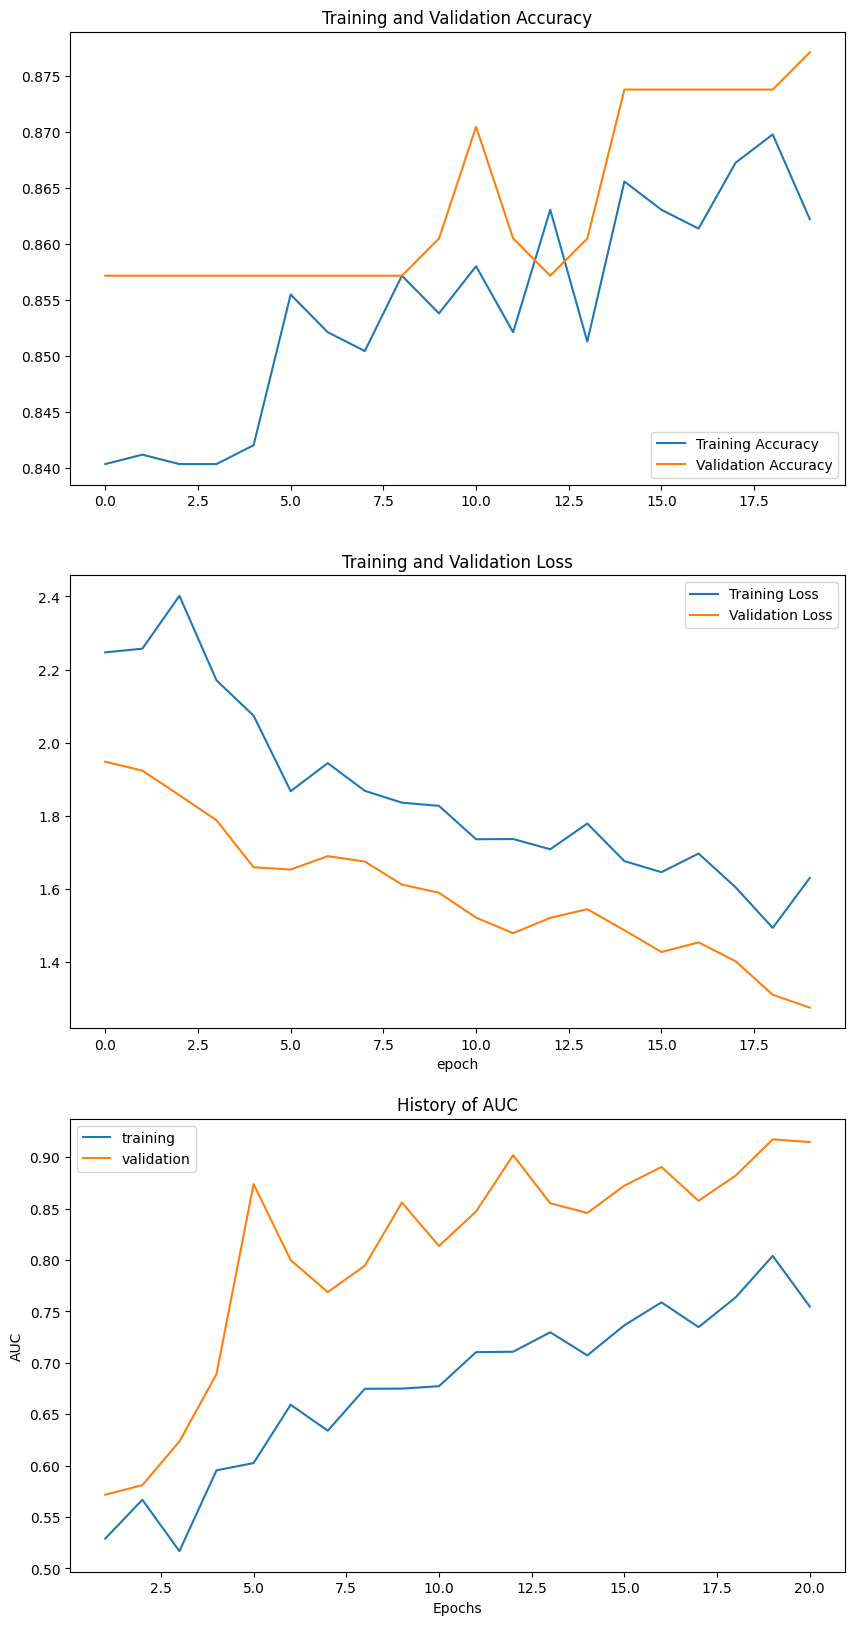

In [17]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()
    

In [18]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.86
Train Loss:  1.63
Train Precision:  0.59
Train Recall:  0.12
Train F1-Score:  0.21


In [19]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.88
Test Loss:  1.27
Test Precision:  1.0
Test Recall:  0.14
Test F1-Score:  0.16


## Fine Tuning

In [20]:
NB_IV3_LAYERS_TO_FREEZE = 172

In [21]:
# Create Callback Checkpoint
filepath="Best1.hdf5"
Checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')

callbacks_list2 = [Checkpoint]

In [22]:
for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = METRICS,   
                 loss='categorical_crossentropy')

In [23]:
fine_tune_epochs = 20
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(train_generator, 
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_test,y_test),
                         callbacks = callbacks_list2)

Epoch 20/40
6/6 [==============================] - 17s 2s/step - loss: 1.7065 - accuracy: 0.8632 - precision: 0.8462 - recall: 0.0516 - auc: 0.7711 - f1_score: 0.0491 - val_loss: 1.3428 - val_accuracy: 0.8738 - val_precision: 0.6667 - val_recall: 0.2326 - val_auc: 0.8428 - val_f1_score: 0.2760
Epoch 21/40
6/6 [==============================] - 15s 3s/step - loss: 1.6453 - accuracy: 0.8588 - precision: 0.6000 - recall: 0.0353 - auc: 0.7547 - f1_score: 0.0793 - val_loss: 1.2849 - val_accuracy: 0.8804 - val_precision: 0.7059 - val_recall: 0.2791 - val_auc: 0.8665 - val_f1_score: 0.3556
Epoch 22/40
6/6 [==============================] - 9s 2s/step - loss: 1.5659 - accuracy: 0.8605 - precision: 0.5833 - recall: 0.0824 - auc: 0.7949 - f1_score: 0.1475 - val_loss: 1.1836 - val_accuracy: 0.8870 - val_precision: 0.7647 - val_recall: 0.3023 - val_auc: 0.8944 - val_f1_score: 0.3778
Epoch 23/40
6/6 [==============================] - 2s 294ms/step - loss: 1.5783 - accuracy: 0.8664 - precision: 0.72

## Quantitative Evaluation

In [24]:
train_acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
train_loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
train_auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

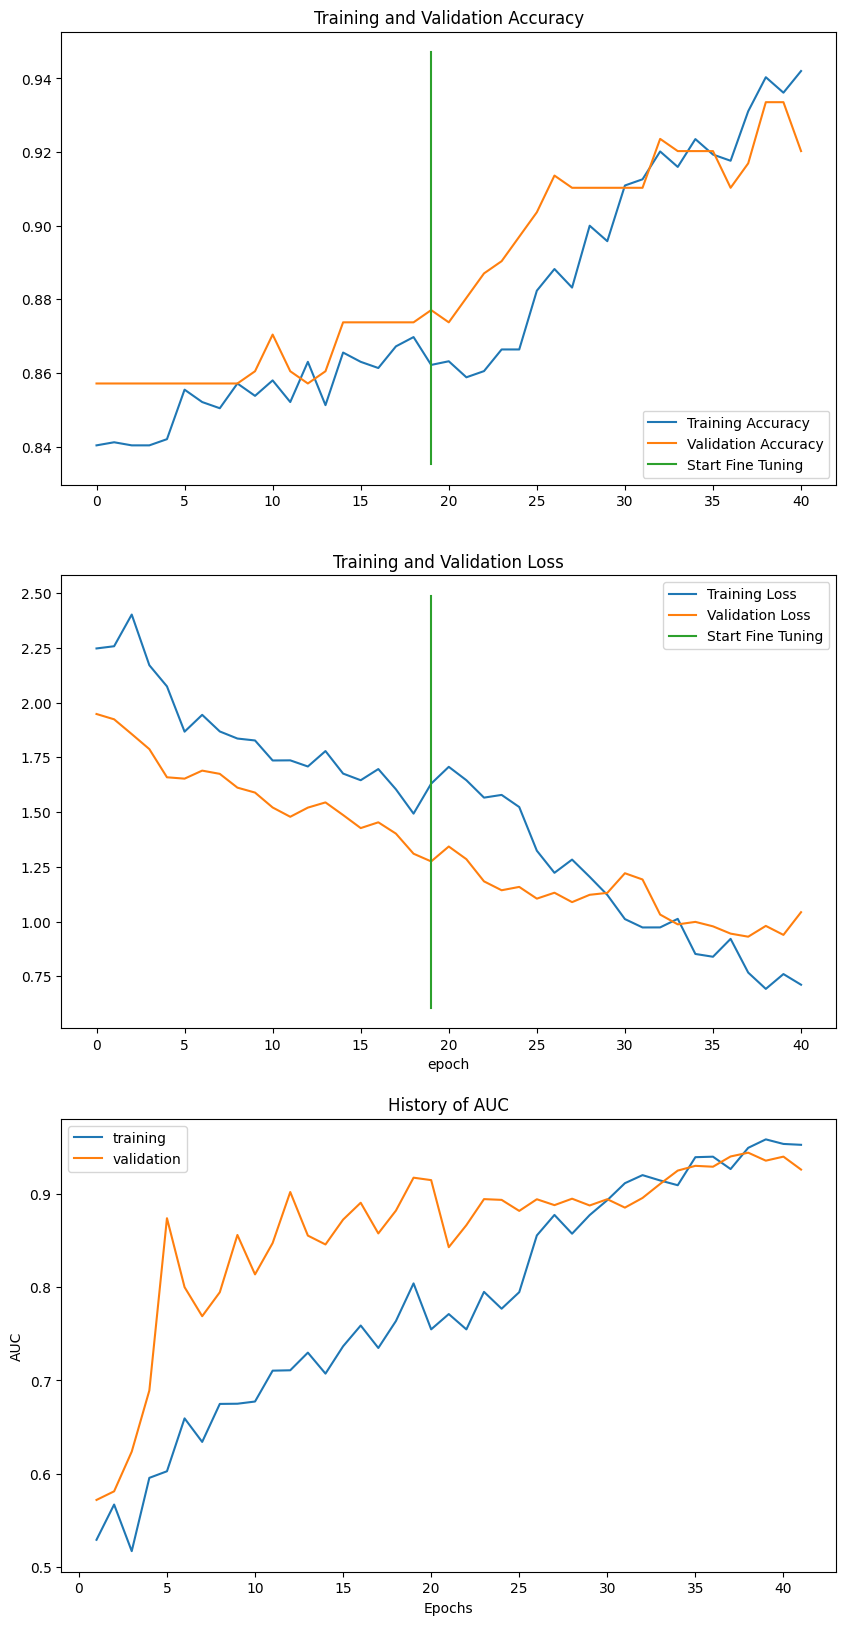

In [25]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()
    

In [26]:
#EVALUATION

print('Train Accuracy: ', round(history_fine.history['accuracy'][-1],2))
print('Train Loss: ', round(history_fine.history['loss'][-1],2))
print('Train Precision: ', round(history_fine.history['precision'][-1],2))
print('Train Recall: ', round(history_fine.history['recall'][-1],2))
print('Train F1-Score: ', round(history_fine.history['f1_score'][-1],2))

Train Accuracy:  0.94
Train Loss:  0.71
Train Precision:  0.84
Train Recall:  0.73
Train F1-Score:  0.81


In [27]:
#EVALUATION

print('Test Accuracy: ', round(history_fine.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history_fine.history['val_loss'][-1],2))
print('Test Precision: ', round(history_fine.history['val_precision'][-1],2))
print('Test Recall: ', round(history_fine.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history_fine.history['val_f1_score'][-1],2))

Test Accuracy:  0.92
Test Loss:  1.04
Test Precision:  0.72
Test Recall:  0.72
Test F1-Score:  0.72


2/2 [==============================] - 1s 102ms/step


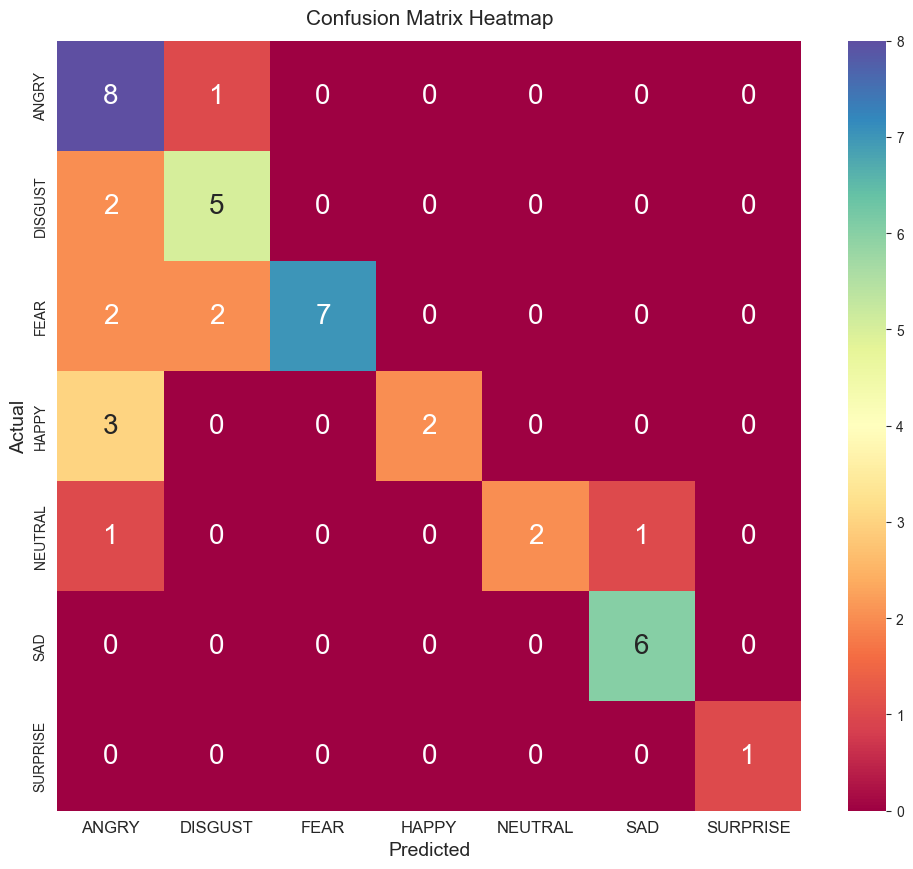

In [28]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(np.where(y_test == 1)[1],Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'], fontdict={'fontsize':10})
plt.show()

## Qualitative Evaluation

In [29]:
last_conv_layer = "mixed7"

Test Loss: 1.042953610420227
Test accuracy: 0.920265793800354
1/1 [==============================] - 0s 245ms/step
[4 0 5 5 2 3 2 5 2]
[4 0 5 5 2 3 2 4 2]


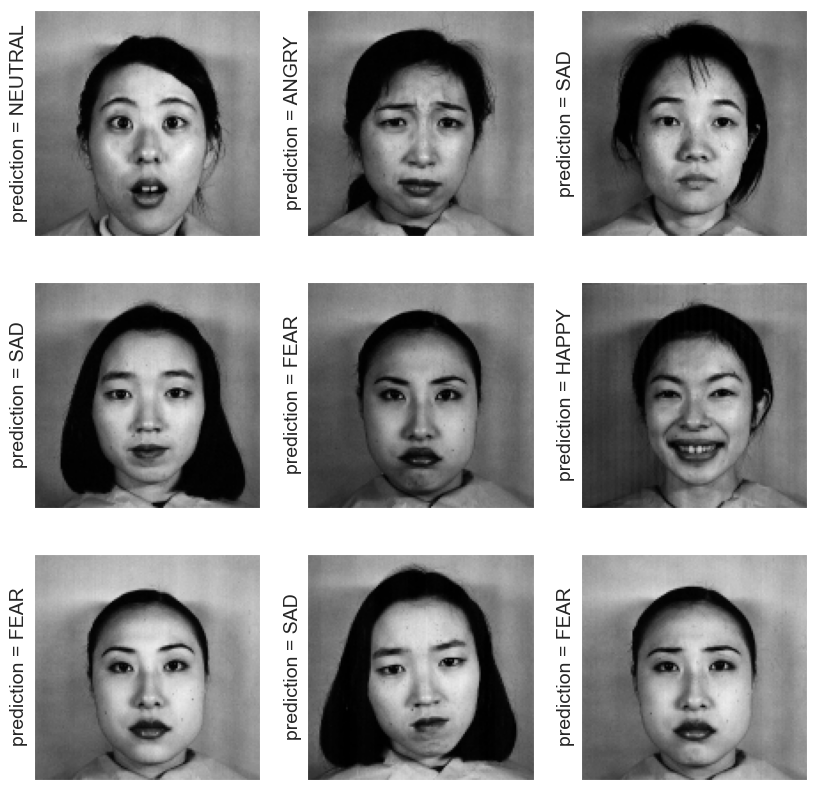

In [30]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

res = model.predict(X_test[:9]).argmax(axis=-1)
print(res)
print(y_test[:9].argmax(axis=-1))
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)

# show the plot
plt.show()
